In case some of the libraries are not installed, we also provided a requirements.txt file.

In [76]:
!pip install pycountry
!pip install pycountry_convert
!unzip data.zip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import pycountry

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')

'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Helpers

In [77]:
## Helpers

import pycountry_convert as pc

def country_to_continent(country_name):
  try:
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name
  except:
    return np.nan


## Load data and initial preprocess

In this exercise we are using 2 datasets in order to answer the question we want to answer, and also to do a predictive model.

The first dataset we use is a dataset from The Times Higher Education (THE) organization. The Times Higher Education (THE) is an organization that has been providing performance data on universities since 2004. Their university rankings aim to assess university performance on the global stage, and serve as a resource for students, academics, university leaders, governments, and industry. These rankings cover three main areas of university activity: research, impact, and teaching. They are designed to help students and their families, academics, university leaders, governments and industry to understand the different missions and successes of higher education institutions.

The second one is the The World Development Indicators data, from which we only select a few indicators we think are worth looking at. The World Development Indicators (WDI) is a dataset provided by the World Bank that contains a wide range of development indicators compiled from officially recognized international sources. This dataset is considered to be the primary collection of development indicators and includes national, regional and global estimates. It provides the most current and accurate global development data available and is used in this analysis.

In [132]:
data = pd.read_csv("./data/timesData.csv")
indicators = pd.read_csv("./data/indicators.csv")

### Indicators

In [133]:
indicators = indicators.iloc[:-5]

In [134]:
indicators.head()

,Country Name,Country Code,Series Name,Series Code,2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021]
0,Afghanistan,AFG,GDP per capita growth (annual %),NY.GDP.PCAP.KD.ZG,1.08498820068206,11.8033826648298,1.86475446570947,17.1435343251686,11.0992199166219,-3.21136429567835,8.24714425211255,2.00252214522922,-0.964803329240652,-1.66641641520391,-0.345802496981889,-0.253593781811986,-1.68857659267114,0.932833388709597,-5.3646659309623,-22.965295860551
1,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,274.000486471348,375.078128065393,387.849174300047,443.845150536332,554.595200222354,621.912310861592,663.141052810937,651.987861948108,628.146803888496,592.476537451681,520.252064031151,530.149830802984,502.056770622973,500.522664145294,516.866552182696,368.754614175459
2,Afghanistan,AFG,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,5.35740325126351,13.8263195479763,3.92498382161573,21.3905283931066,14.3624414692681,0.426354784529209,12.7522870887171,5.60074465808154,2.72454336394854,1.45131466009755,2.26031420130452,2.64700320195786,1.18922812838034,3.911603419423,-2.35110067344623,-20.7371456208414
3,Afghanistan,AFG,"CPIA transparency, accountability, and corrupt...",IQ.CPA.TRAN.XQ,2.5,2,2,2,2,2,2,2,2,2,2,2,2,2,2,..
4,Afghanistan,AFG,Human capital index (HCI) (scale 0-1),HD.HCI.OVRL,..,..,..,..,..,..,..,..,..,..,..,0.389,0.393489241600037,..,0.400284141302109,..


In the following part we are doing data preprocessing on the indicators data frame. Firstly, we are reshaping the dataframe from wide format to long format using the `pd.melt()` function. This is done by specifying the id variables ('Country Name', 'Country Code', 'Series Name'), the value variables ('2006 [YR2006]', '2007 [YR2007]', ...), and the name of the new variable that will be created to represent the old columns ('Year'). Then, the data is being pivoted back to wide format using the `pivot()` function, where the new index is ('Country Name', 'Country Code', 'Year'), columns are 'Series Name' and values are 'value', and resetting the index. Afterwards we do some cleaning steps such as: 
- The 'Year' column is being cleaned by splitting the text on space, keeping the first element and converting it to integer.
- 'Country Name' and 'Country Code' columns are being cleaned by converting them to lowercase and striping the leading/trailing whitespaces.
- Adding a new column called 'continent' to the dataframe, by applying a function called `country_to_continent()` on the 'Country Name' column, which maps the country name to the continent name. This we later help us to join the two dataframes together
- Finally, replacing all the '..' values in the dataframe with NaN values. This is done to replace missing values with NaN, to make it easier to identify missing values and to handle them properly.

In [135]:
indicators = pd.melt(indicators, id_vars=['Country Name', 'Country Code', 'Series Name'], value_vars=['2006 [YR2006]', '2007 [YR2007]', '2008 [YR2008]', '2009 [YR2009]',
       '2010 [YR2010]', '2011 [YR2011]', '2012 [YR2012]', '2013 [YR2013]',
       '2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]', '2017 [YR2017]',
       '2018 [YR2018]', '2019 [YR2019]', '2020 [YR2020]', '2021 [YR2021]'], var_name = 'Year')

indicators = indicators.pivot(index=['Country Name', 'Country Code', 'Year'], columns='Series Name', values='value').reset_index()
indicators.loc[:, 'Year'] = indicators.Year.str.split(' ').str[0].astype(int)
indicators['Country Name'] = indicators['Country Name'].str.lower().str.strip()
indicators['Country Code'] = indicators['Country Code'].str.lower().str.strip()

indicators.loc[:, 'continent'] = indicators.apply(lambda x: country_to_continent(x['Country Name'].title()), axis = 1)

for col in indicators.columns:
    indicators[col] = indicators[col].replace('..', np.nan)

In [136]:
indicators[[c for c in indicators.columns if c not in ['Country Name','Country Code',"Year",'continent']]] = indicators[[c for c in indicators.columns if c not in ['Country Name','Country Code',"Year",'continent']]].astype(float)

### The Times Higher Education Data

In the following code, data cleaning and manipulation is being performed on the times dataframe:

- Some wrong country names are being replaced with their correct versions.
- A loop is being run through all unique country names in the 'country' column.
- Within the loop, the alpha_3 country code is being looked for each country name using the 'pycountry' library. If it can't find it, a fuzzy match is being searched. If it still can't find it, the official_name of the country is being looked for. If it couldn't find any of the above, the country code is being replaced with NaN, and rows that contain NaN values are being dropped.

This is done to make sure that the country name is correct and there's a matching country code for it, and to make it easier to join the data with other dataframes.

In [137]:
data['country'] = data['country'].str.replace('Unisted States of America', 'United States of America')
data['country'] = data['country'].str.replace('Unted Kingdom', 'United Kingdom')
data['country'] = data['country'].str.replace('Republic of Ireland', 'Ireland')


In [138]:
for country in data['country'].unique():
    try:
        data.loc[data['country'] == country, 'country code']  = pycountry.countries.get(name = country).alpha_3.lower()
    except:
        try:
            data.loc[data['country'] == country, 'country code'] = pycountry.countries.search_fuzzy(country)[0].alpha_3.lower()
        except:
            try:
                data.loc[data['country'] == country, 'country code'] = pycountry.countries.get(official_name = 'country').lower()
            except:
                data.loc[data['country'] == country, 'country code'] = np.nan
                data = data[data['country code'].notna()]

### Dealing with missing values in times data

In this part we handling missing values in the dataframe "data" by using various methods such as replacing the missing values with the median or mean values of the specific column grouped by "country code" and use of fillna() function. Also, we calculate the optimal weights for the dependent variables and creating a new column "total_score" to store the calculated score. Then we are changing the format of certain columns, renaming some columns, and dropping some unnecessary columns. The goal of this code is to improve the quality of the data and make it ready for analysis.

In [139]:
data = data.replace('-', np.nan)
data.international = data.international.astype(float)

In [140]:
# Calculate the percentage of missing values for each column
missing_values = data.isna().sum() / len(data) * 100

# Convert the output to a tabular form
missing_values = pd.DataFrame(missing_values.round(1), columns=['Missing Values Percentage'])

# Print the table
print(missing_values)

                        Missing Values Percentage
world_rank                                    0.0
university_name                               0.0
country                                       0.0
teaching                                      0.0
international                                 0.4
research                                      0.0
citations                                     0.0
income                                        8.3
total_score                                  53.1
num_students                                  2.3
student_staff_ratio                           2.3
international_students                        2.6
female_male_ratio                             9.1
year                                          0.0
country code                                  0.0


In [141]:
data = data.sort_values(by = ['university_name', 'year'])

median_value_international = data.groupby('country code')['international'].transform('median')
data.international = data.international.fillna(median_value_international)

data.income = data.income.astype(float)
median_value_income = data.groupby('country code')['income'].transform('mean')
data.income = data.income.fillna(median_value_income)

In [142]:
import numpy as np
from scipy.optimize import minimize

# Define the values for the dependent variables
teaching = 99.7
international = 72.4
research = 98.7
citations = 98.8
income = 34.5

# Define the target total score
target_score = 96.1

# Define the function to minimize
def score_diff(weights):
    # Calculate the total score using the weights and dependent variables
    total_score = (weights[0] * teaching) + (weights[1] * international) + (weights[2] * research) + (weights[3] * citations) + (weights[4] * income)
    # Return the difference between the target score and the calculated score
    return abs(target_score - total_score)

# Initialize the weights for the dependent variables
weights = np.array([0.2, 0.1, 0.3, 0.25, 0.15])

# Use minimize function from scipy.optimize to find the optimal weights
res = minimize(score_diff, weights, method='SLSQP')

# Print the optimal weights

w1 = res.x[0] 
w2 = res.x[1]
w3 = res.x[2]  
w4 = res.x[3]  
w5 = res.x[4] 

tot_score = (w1 * data.teaching) + (w2 * data.international) + (w3 * data.research) + (w4 * data.citations) + (w5 * data.income)
data.total_score = data.total_score.fillna(tot_score.round(1))
data.total_score = data.total_score.astype(float)

In [143]:
data.num_students = data.num_students.str.replace(",",'')
data.num_students  = data.num_students.astype(int, errors='ignore')
data['num_students'] = data['num_students'].fillna(data.groupby('country code')['num_students'].transform('median'))

data.rename(columns = {'international_students':'international_students (%)'}, inplace = True)
data["international_students (%)"] = data["international_students (%)"].str.replace("%",'')
data["international_students (%)"]  = data["international_students (%)"].astype(int, errors='ignore')
data["international_students (%)"] = data["international_students (%)"].fillna(data.groupby('country code')['num_students'].transform('median'))

data = data.drop(['student_staff_ratio', 'female_male_ratio'], axis = 1)

In [144]:
# Calculate the percentage of missing values for each column
missing_values = data.isna().sum() / len(data) * 100

# Convert the output to a tabular form
missing_values = pd.DataFrame(missing_values.round(1), columns=['Missing Values Percentage'])

# Print the table
print(missing_values)

                            Missing Values Percentage
world_rank                                        0.0
university_name                                   0.0
country                                           0.0
teaching                                          0.0
international                                     0.0
research                                          0.0
citations                                         0.0
income                                            0.0
total_score                                       0.0
num_students                                      0.0
international_students (%)                        0.0
year                                              0.0
country code                                      0.0


### Fix world rank column

In this part the code is manipulating the column "world_rank" in the dataframe "data" by performing various operations like replacing certain characters, extracting the numbers, converting it to numeric format, sorting values, ranking the values and filling missing values. The goal of this code is to fix the format of the "world_rank" column and make it ready for analysis.

In [145]:
data.world_rank = data.world_rank.str.replace('=', '')

data['group_rank'] = data['world_rank']

data.loc[data['world_rank'].str.contains('-', na=False), 'group_rank'] = data['world_rank'].str.extract('(\d+)').astype(int)

data['group_rank'] = pd.to_numeric(data['group_rank'], errors='coerce')

data = data.sort_values(by=['year','total_score'], ascending=[True,False])

data['group_rank'] = data.groupby(['year'])['total_score'].rank(method = 'first', ascending=False)

data.loc[data['world_rank'].str.contains('-', na=False), 'world_rank'] = np.nan
data.world_rank = data.world_rank.fillna(data.group_rank).astype(float)


## Data merge and additional missing values

The code is performing data merge, dealing with missing values, and cleaning operations on the dataframe. It is merging the times dataframe with the indicators dataframe on specific columns, dropping columns with a high percentage of missing values, sorting the values, interpolating the missing values, filling remaining missing values using median values of the same columns grouped by "continent" column, and finally dropping the "continent" column. The goal of this code is to join the data from multiple sources and make it ready for analysis by handling the missing values.

In [146]:
data = data.merge(indicators, left_on = ['country code', 'year'], right_on = ['Country Code', 'Year'])

In [147]:
missing = data.isna().sum().sort_values() / len(data) * 100
drop_cols = missing[missing > 65].index.unique().tolist()

data = data.drop(drop_cols, axis = 1)
data = data.sort_values(by = ['world_rank', 'Year'])

In [148]:
data = data.groupby(['Country Name', 'Country Code']).apply(lambda group: group.interpolate())

missing_helper = data.isna().sum().sort_values() / len(data) * 100

for col in missing_helper[missing_helper > 0].index:
    if col != 'continent':
        data[col] = data[col].fillna(data.groupby('continent')[col].transform('median'))
        data[col] = data[col].fillna(0)

data.drop('continent', axis = 1, inplace = True)

In [149]:
data.world_rank = data.world_rank.astype(int)

## Data Analysis and Visualization

In [150]:
px.box(data, x = 'country', y = 'world_rank', color_discrete_sequence=['darkcyan'])

# Visualizing mean world ranking against different indicator values

In this part we would like to show couple of examples for USA, Singapore and Switzerland and see how are different indicator value impacting the mean worl rank of these countries over the years.

In [151]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_mean_world_rank(data,country_name,column):
  test = data[data["country"] == country_name]
  test1 = test.groupby(["year"])["world_rank"].mean().rename("mean")
  test1 = test1.to_frame()
  test1 = test1.reset_index()
  # Create figure with secondary y-axis
  fig = make_subplots(specs=[[{"secondary_y": True}]])

  # Add traces
  fig.add_trace(
      go.Scatter(x=test1['year'], y=test1["mean"], name="mean world ranking"),
      secondary_y=False,
  )

  fig.add_trace(
      go.Scatter(x=test1['year'], y=test[column], name=column),
      secondary_y=True,
  )


  # Add figure title
  fig.update_layout(
      title_text="Movement of mean world ranking over the year for " + country_name
  )



  # Set x-axis title
  fig.update_xaxes(title_text="year")

  # Set y-axes titles
  fig.update_yaxes(title_text="mean world ranking", secondary_y=False)
  fig.update_yaxes(title_text=column,title_font = {"size": 10}, secondary_y=True)

  fig.show()





We will first the impact of GDP per capita on mean world ranking for USA. From the plot below we can see that even if the USA has bigger GDP per capita their mean world rank is getting bigger (which is not positive side because lower the rank it means that university is better).

In [152]:
plot_mean_world_rank(data,"United States of America",'GDP per capita (current US$)')

We can conclude the same when we are comparing mean world rank against Government expenditure on education for USA.

In [162]:
plot_mean_world_rank(data,"United States of America",'Government expenditure on education, total (% of GDP)')

In this plot we can see that mean world rank during the period from 2012-2015 did not change that much despite that in 2015 there was a 1% less education expenditure. And we can also see that after that 2015 year where there was 1% less education expenditure that mean world ranking grew bigger (which is not positive effect).

In [154]:
plot_mean_world_rank(data,"United States of America", 'Current education expenditure, total (% of total expenditure in public institutions)')

Now we will present a positive effect from Singapore in which growth in GDP per capita is also influencing mean world rank in a negative way (which means that rank is getting smaller which actually means that universities are getting better)

In [155]:
plot_mean_world_rank(data,"Singapore",'GDP per capita (current US$)')

In [156]:
plot_mean_world_rank(data,"Singapore",'Government expenditure on education, total (% of GDP)')

We can see that year 2014 was a year where Singapore started investing more and more money into education and results, in terms of mean world ranking, where there immediately. Singapore is an example where education is getting better with more investing.

In [157]:
plot_mean_world_rank(data,"Singapore", 'Current education expenditure, total (% of total expenditure in public institutions)')

Here we are showing how ranking of Switzerland has changed over the years. In this example we cannot see a clear trend in terms of ranking and gdp per capita growth. We can see that in year 2015 rank got better with growth of gdp per capita but next year the rank got worse.

In [158]:
plot_mean_world_rank(data,"Switzerland",'GDP per capita (current US$)')

In [159]:
plot_mean_world_rank(data,"Switzerland",'Government expenditure on education, total (% of GDP)')

In [160]:
plot_mean_world_rank(data,"Switzerland", 'Current education expenditure, total (% of total expenditure in public institutions)')

In [106]:
top10_best2011 = data[data['year'] == 2011].iloc[:10]
top10_best2012 = data[data['year'] == 2012].iloc[:10]
top10_best2013 = data[data['year'] == 2013].iloc[:10]
top10_best2014 = data[data['year'] == 2014].iloc[:10]
top10_best2015 = data[data['year'] == 2015].iloc[:10]
top10_best2016 = data[data['year'] == 2016].iloc[:10]

In [107]:
top10_con = pd.concat([top10_best2011,top10_best2012,top10_best2013, top10_best2014, top10_best2015, top10_best2016])

In [108]:
px.scatter(top10_con ,x = 'year', y = 'world_rank', color="university_name")

From the plots above we can see that USA always have high ranked universities in the world. Some examples are Harvard, Stanford, California Institute of Technology etc. And we would expect that USA would have best mean rank overvall when it comes to countries. 

But when we visualize mean world rank against some indicators we would also expect that with investing more and more money into education that mean world rank will get better? But it is actually not (in case of USA). We can see that mean world rank over the years for USA actually got worse. Since we are limited with information we can only guess why this is happening. One guess would be that more and more universities are opened in USA and are getting starting rank which is bad (because they just started). One can also say that USA has the most universities in this dataset (they have 161 unqiue universities) which is also affecting the mean world rank.



As a second example we provided universities from Singapore where we can clearly see a trend when it comes to mean world rank and other indicators.

# Vizualisaion of universities with highest growth in rank

In [109]:
top10_universities = data[data.world_rank <= 10].university_name.unique()
top100_universities = data[data.world_rank.between(11,100)].university_name.unique()
top500_universities = data[data.world_rank.between(100,500)].university_name.unique()

yearly_rank = pd.pivot_table(data[['university_name','year','world_rank']],index = 'university_name',columns = 'year').reset_index()
yearly_rank.columns = ['university_name','2011 rank','2012 rank','2013 rank','2014 rank','2015 rank','2016 rank']

In [173]:
change_in_rank = data.groupby(['country','university_name']).apply(lambda x:x.sort_values('year').iloc[0].world_rank-  x.sort_values('year').iloc[-1].world_rank ).to_frame('rank_change').reset_index()


def vizualize_change_in_rank(rank_class):
    if rank_class == 10:
        top_changes = change_in_rank[change_in_rank.university_name.isin(top10_universities)].sort_values('rank_change',ascending = False)
        top_changes = top_changes.merge(yearly_rank)
    elif rank_class == 100:
        top_changes = change_in_rank[change_in_rank.university_name.isin(top100_universities)].sort_values('rank_change',ascending = False)
        top_changes = top_changes.merge(yearly_rank)
    else:
        top_changes = change_in_rank[change_in_rank.university_name.isin(top500_universities)].sort_values('rank_change',ascending = False)
        top_changes = top_changes.merge(yearly_rank)
        
    
        
    temp = data[data.university_name.isin(top_changes.head(10).university_name)].reset_index().drop('index',axis =1)
    plt.figure(figsize=(15,10))

    ax = sns.lineplot(x='year', y='world_rank', hue='university_name', data=temp, marker='o', markersize=10)
    plt.xlabel('Year')
    plt.ylabel('Rank')
    plt.legend(bbox_to_anchor = (1,1))
    plt.title(f'10 highest Universities by increase in rank that belong in Top {rank_class}')

    for index, line in temp.iterrows():
        plt.annotate(int(line.world_rank), 
                     xy=(line.year, int(line.world_rank)), 
                     xytext=(5,5), 
                     textcoords='offset points',
                     ha='left',
                     va='bottom')
        
    
    plt.show()


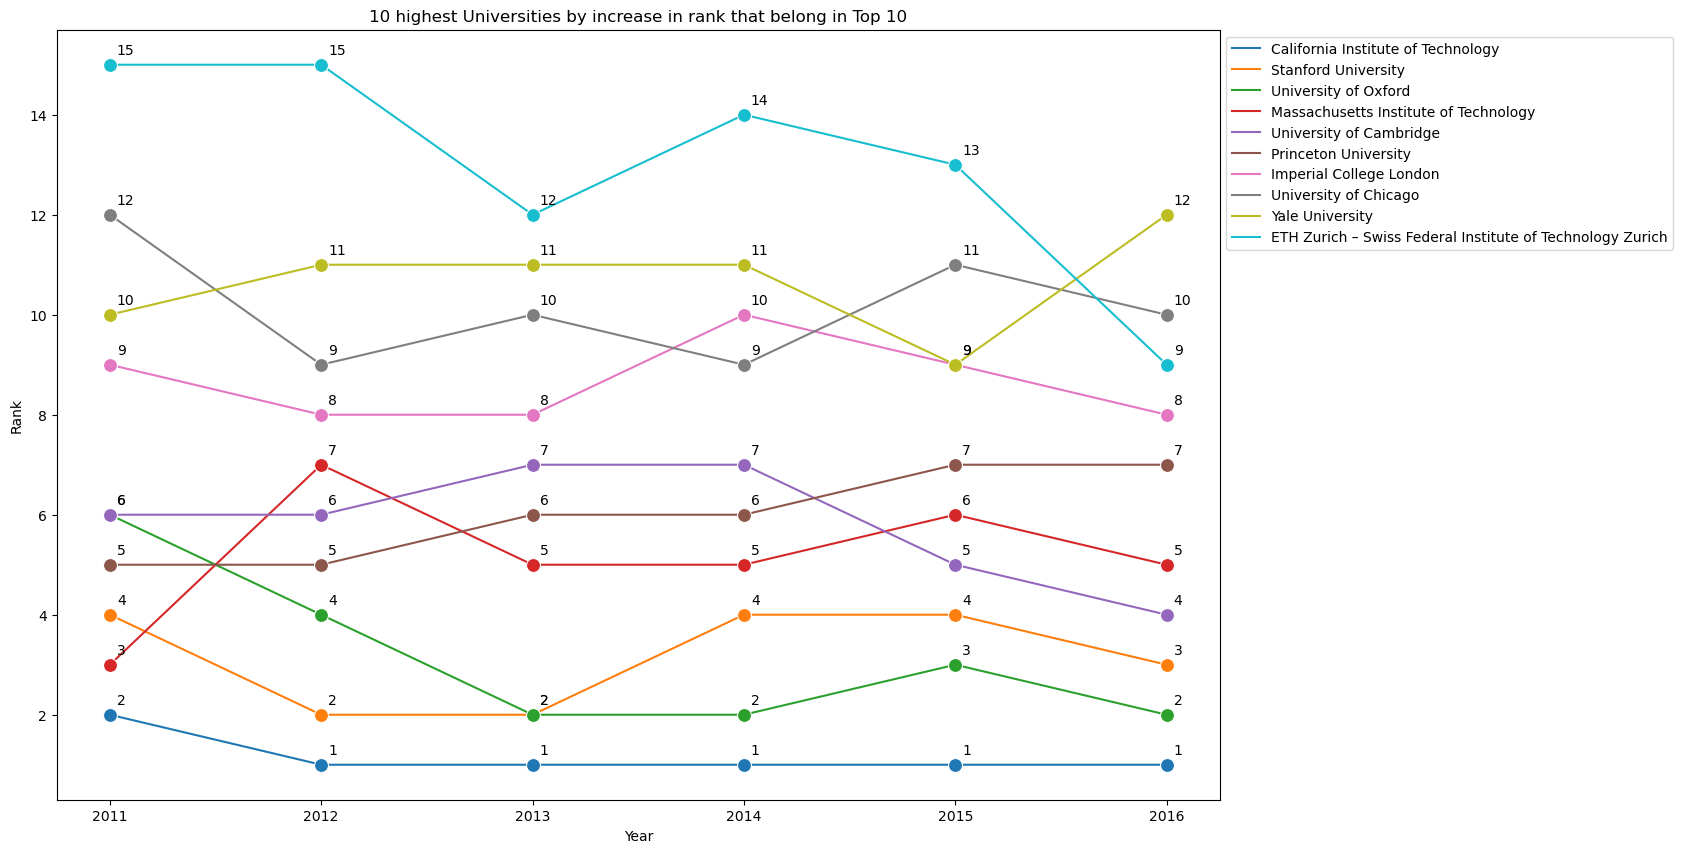

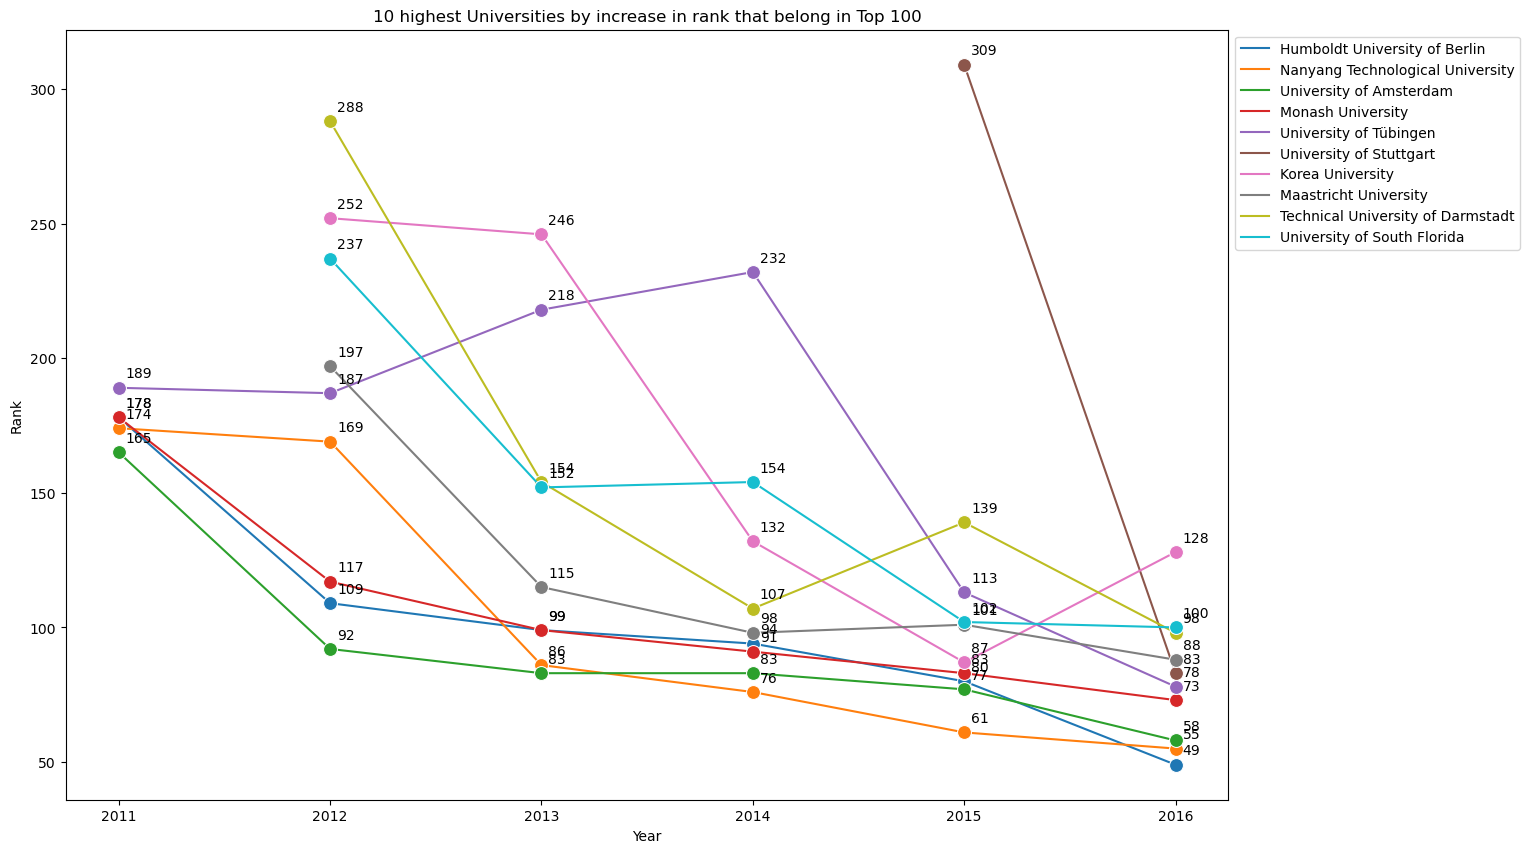

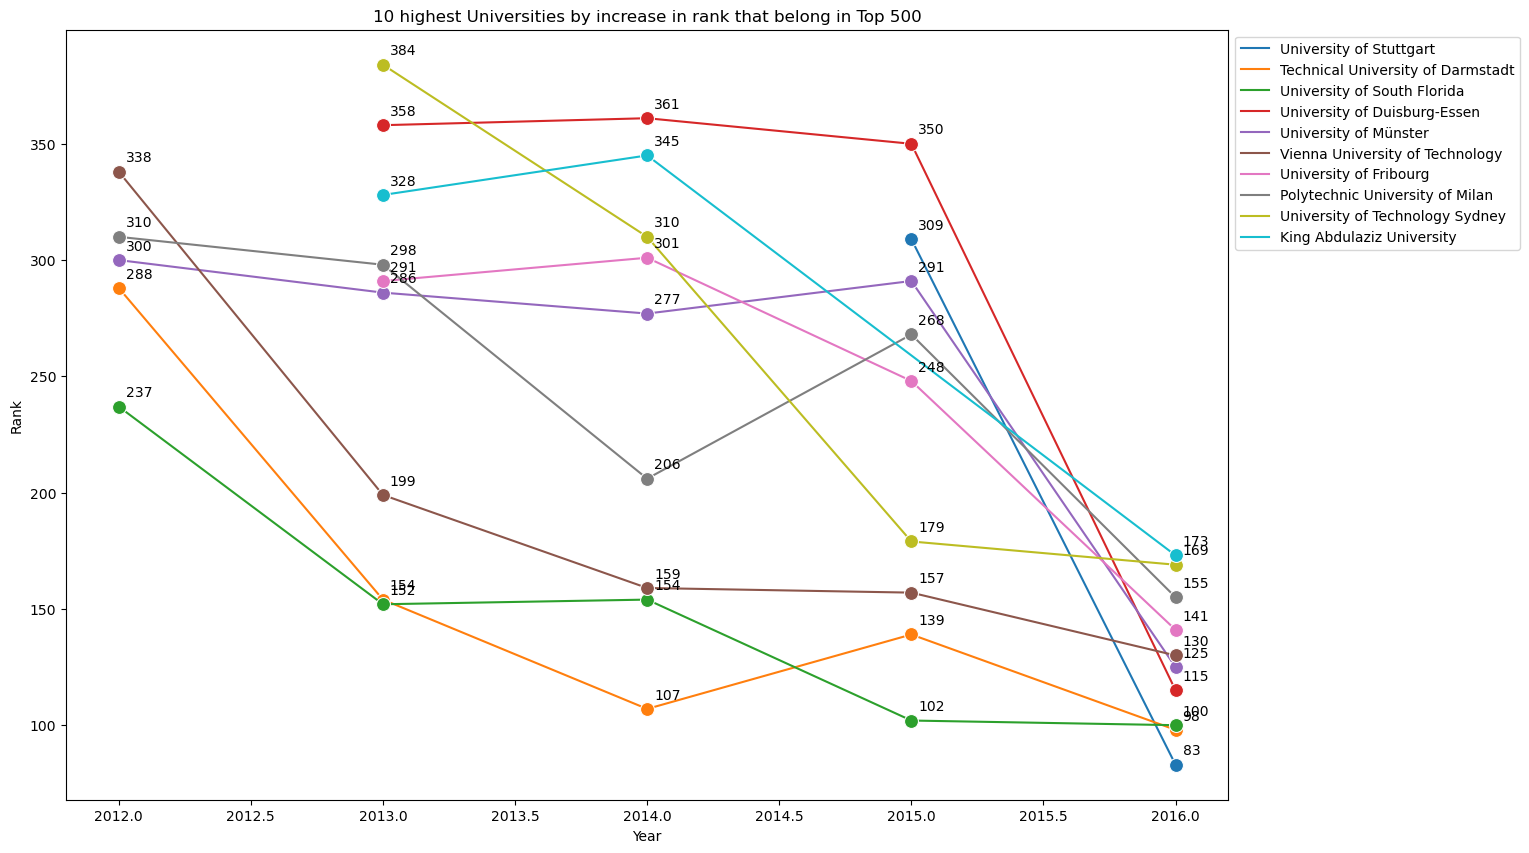

In [174]:
vizualize_change_in_rank(10)
vizualize_change_in_rank(100)
vizualize_change_in_rank(500)

## Prediction model

The code is creating a prediction pipeline for a university ranking dataset. It performs data cleaning, manipulation, and feature engineering to prepare the data for training and testing a model. It uses a pipeline structure with preprocessing steps such as scaling and encoding, and applies several machine learning models using cross-validation and holdout method to evaluate their performance. The pipeline also provides evaluation metrics such as precision, recall and f1-score for the different models, and confusion matrix for the best performing one.

We use 4 different classifiers:
- Decision Tree Classifier: A decision tree is a tree-like model of decisions and their possible consequences. Decision trees are used for classification and regression.

- SVM Classifier: Support Vector Machine is a supervised algorithm that can be used for classification and regression. The goal of the SVM algorithm is to find the best boundary between the different classes.

- K Nearest Neighbour Classifier: KNN is a classification algorithm that classifies an input point based on its proximity to other points in the dataset. It looks at the k-nearest points to an input and assigns it the class that is most common among those k-nearest points.

- Naive Bayes Classifier: Naive Bayes is a probabilistic algorithm that makes classifications based on the probability of an input belonging to a certain class. It makes the assumption that all features are independent of one another, which is why it is called "naive".


We redefined the problem to a classification problem in which we predict in which category a university will belong to. The categories we define are:
- top 10
- top 100(meaning 11-1000)
- top 500(meaning 100-500)
- below 500(we exclude these, since there are not enough instances for training, validation, and testing)

In [55]:
data = data.sort_values(by = ['Year', 'world_rank'])
data["target"] = data["world_rank"].apply(lambda x: 'top10' if x <=10 else 'top100' if x>10 and x<=100 else 'top500' if x>100 and x<=500 else '501-1000')
data = data.set_index(['university_name', 'Year']).drop(['year', 'country' ,'Country Name', 'country code', 'Country Code', 'group_rank', 'world_rank'], axis = 1)
data = data[data.target != '501-1000']
for col in data.columns:
    if col != 'target':
        data[col] = data[col].astype(float)

In [56]:
train = data[data.index.get_level_values(1) < 2016 ]
test = data[data.index.get_level_values(1) == 2016]

X = train.drop('target', axis = 1)
y = train['target']

X_test = test.drop('target', axis = 1)
y_test = test['target']

X_train = train[train.index.get_level_values(1) < 2015 ].drop('target', axis = 1)
y_train = train[train.index.get_level_values(1) < 2015 ]['target']
X_val = train[train.index.get_level_values(1) == 2015 ].drop('target', axis = 1)
y_val = train[train.index.get_level_values(1) == 2015 ]['target']

In [57]:
numeric_features = data.columns.tolist()[:-1]

def create_preprocessor(drop, cols_drop=None):
    global numeric_features
    global ordinal_categorical_features

    numeric_transformer = Pipeline(
        steps=[("scaler", StandardScaler())]
    )

    #ordinal_categorical_transformer = Pipeline(steps = [("fillna"), ('encoder', OrdinalEncoder())])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
        ]
    )
    
    return preprocessor

In [58]:
scoring = ['precision_macro', 'recall_macro', 'f1_macro']
metrics = pd.DataFrame(columns = ['Model', 'Macro Precision', 'Macro Recall', 'Macro F1'])

In [59]:
def benchmark_pipe(model,metrics,X,y,X_train, X_val, y_train, y_val):
    
    model_name = type(model).__name__
   
    # Define Pipeline steps
    preprocessor = create_preprocessor(drop = False)
    piped_model = Pipeline(steps=[('preprocessor', preprocessor) ,("classifier", model)])
    # Fit Model
    piped_model.fit(X_train,y_train)
    
    # Make Predictions
    y_pred = piped_model.predict(X_val)
    
    # Evaluate Results
    precision,recall,fscore,_=score(y_val,y_pred,average='macro')
    metrics = metrics.append({'Model': f'{model_name} Holdout','Macro Precision': precision.round(2),
                              'Macro Recall': recall.round(2),'Macro F1': fscore.round(2)}, ignore_index=True)
    
    cf_matrix = confusion_matrix(y_val, y_pred)
    # CrossValidation 
    output = cross_validate(piped_model, X, y, cv=10, scoring = scoring, return_estimator = True)
    prec_macro = output['test_precision_macro'].mean().round(2)
    rec_macro = output['test_recall_macro'].mean().round(2)
    f1_macro = output['test_f1_macro'].mean().round(2)
    
    metrics = metrics.append({'Model': f'{model_name} CV','Macro Precision': prec_macro.round(2),
                              'Macro Recall': rec_macro.round(2),'Macro F1': f1_macro.round(2)}, ignore_index=True)
    
    return metrics, piped_model, output

In [60]:
%%time
metrics, dt_clf,output_dt = benchmark_pipe(DecisionTreeClassifier(),metrics,X,y,X_train, X_val, y_train, y_val)

Wall time: 563 ms


In [61]:
%%time
metrics,svm_clf,output_svm = benchmark_pipe( SVC(kernel = 'linear'),metrics,X,y,X_train, X_val, y_train, y_val)

Wall time: 1.06 s


In [62]:
%%time
metrics,knn_clf,output_knn = benchmark_pipe(KNeighborsClassifier(),metrics,X,y,X_train, X_val, y_train, y_val)

Wall time: 687 ms


In [63]:
%%time
metrics,nb_clf,output_nb = benchmark_pipe(GaussianNB(),metrics,X,y,X_train, X_val, y_train, y_val)

Wall time: 422 ms


The table shows the performance of four different machine learning models (Decision Tree, SVM, KNN, and Naive Bayes) in terms of Macro Precision, Macro Recall, and Macro F1. The models were trained using a training dataset and evaluated using a validation dataset and 10-fold cross-validation.

The Decision Tree Classifier model performs well in both Holdout and cross-validation, with high values of Macro Precision, Macro Recall and Macro F1. SVM and KNN models also shows good results in Holdout but not in cross-validation, their performance is slightly lower.

On the other hand, Naive Bayes classifier performs poorly in both Holdout and cross-validation, with low values of Macro Precision, Macro Recall and Macro F1, suggesting that this model may not be suitable for this dataset.

In [64]:
metrics

,Model,Macro Precision,Macro Recall,Macro F1
0,DecisionTreeClassifier Holdout,0.94,0.96,0.95
1,DecisionTreeClassifier CV,0.94,0.94,0.94
2,SVC Holdout,0.98,0.95,0.97
3,SVC CV,0.95,0.94,0.94
4,KNeighborsClassifier Holdout,0.91,0.89,0.90
5,KNeighborsClassifier CV,0.91,0.89,0.89
6,GaussianNB Holdout,0.83,0.94,0.88
7,GaussianNB CV,0.80,0.91,0.83


### Prediction on test set

The results below show the performance of 4 different algorithms (Decision Tree, SVM, k-NN and Naive Bayes) on a holdout test set. The performance is measured by precision, recall and f1-score.

The Decision Tree classifier has a high precision, recall and f1-score for all 3 categories (top10, top100, top500) with an overall accuracy of 90%. The SVM classifier also has a high precision, recall and f1-score for all 3 categories with an overall accuracy of 91%. The k-NN classifier has a lower precision and recall for the top100 category, but still has a good overall accuracy of 92%.The Naive Bayes classifier has a lower precision and recall for all 3 categories compared to the other algorithms and an overall accuracy of 88%.

Overall, it seems that the Decision Tree and SVM classifiers perform the best on this test set, while the Naive Bayes classifier performs the worst.

In [65]:
prd_test = dt_clf.predict(X_test)
print(classification_report(y_test, prd_test))

              precision    recall  f1-score   support

       top10       1.00      0.70      0.82        10
      top100       0.63      1.00      0.77        94
      top500       1.00      0.87      0.93       389

    accuracy                           0.89       493
   macro avg       0.88      0.86      0.84       493
weighted avg       0.93      0.89      0.90       493



In [66]:
prd_test = svm_clf.predict(X_test)
print(classification_report(y_test, prd_test))

              precision    recall  f1-score   support

       top10       0.89      0.80      0.84        10
      top100       0.69      0.95      0.80        94
      top500       0.99      0.90      0.94       389

    accuracy                           0.91       493
   macro avg       0.86      0.88      0.86       493
weighted avg       0.93      0.91      0.91       493



In [67]:
prd_test = knn_clf.predict(X_test)
print(classification_report(y_test, prd_test))

              precision    recall  f1-score   support

       top10       0.90      0.90      0.90        10
      top100       0.75      0.85      0.80        94
      top500       0.97      0.94      0.95       389

    accuracy                           0.92       493
   macro avg       0.87      0.90      0.88       493
weighted avg       0.92      0.92      0.92       493



In [68]:
prd_test = nb_clf.predict(X_test)
print(classification_report(y_test, prd_test))

              precision    recall  f1-score   support

       top10       0.53      0.90      0.67        10
      top100       0.63      0.90      0.74        94
      top500       1.00      0.87      0.93       389

    accuracy                           0.88       493
   macro avg       0.72      0.89      0.78       493
weighted avg       0.92      0.88      0.89       493



In [161]:
labels = knn_clf.predict(X_val)

fig = px.scatter_3d(X_val, x='teaching', y='research', z='citations', color=labels)
fig.update_layout(title = 'University ranking predictions by teaching, citations, and research', legend=dict(title='Prediction'))
fig.update_layout(width=800, height=600)

fig.show()
